In [1]:
import multiprocessing
import os
import random
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from rfa import RandomForestAttack

In [2]:
# Load MNIST dataset from OpenML
FILE_NAME = 'mnist.p'

if os.path.isfile(FILE_NAME):
    data = pickle.load(open(FILE_NAME, 'rb'))
else:
    data = fetch_openml('mnist_784', version=1)
    pickle.dump(data, open(FILE_NAME, 'wb'))
X = data.data
y = data.target.astype(np.int64)

In [3]:
# Rescaling to [-1, 1]
X_max = np.max(X)
X_min = np.min(X)
X = 1 - 2 * (X - X_min)/(X_max - X_min)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [5]:
# Hyperparameters
N_THREADS = multiprocessing.cpu_count()
N_TREES = 16
EPSILON = 1e-4  # The minimum change to update a feature.
MAX_BUDGET = 0.01 * X.shape[1]   # The max. perturbation is allowed.
SIZE = 100

In [6]:
# Train model
rf_model = RandomForestClassifier(n_estimators=N_TREES)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
print('Accuracy on train set:', rf_model.score(X_train, y_train))
print('Accuracy on test set: ', rf_model.score(X_test, y_test))

Accuracy on train set: 0.9999166666666667
Accuracy on test set:  0.9588


In [8]:
attack = RandomForestAttack(rf_model, max_budget=MAX_BUDGET, epsilon=EPSILON,
                            rule='least_leaf', n_threads=N_THREADS)

In [9]:
print('Number of threads: {}'.format(N_THREADS))
print('Genearting {} adversarial examples'.format(SIZE))

start = time.time()
X_adv = attack.generate(X_test[:SIZE], y_test[:SIZE])
time_elapsed = time.time() - start

print('Time to complete: {:d}m {:.3f}s'.format(int(time_elapsed // 60), time_elapsed % 60))

Number of threads: 6
Genearting 100 adversarial examples
String the   10th data point...
String the   20th data point...
String the   30th data point...
String the   40th data point...
String the   50th data point...
String the   60th data point...
String the   70th data point...
String the   80th data point...
String the   90th data point...
String the  100th data point...
Time to complete: 1m 23.667s


In [10]:
y_pred = rf_model.predict(X_test[:SIZE])
acc = np.count_nonzero(y_pred == y_test[:SIZE]) / SIZE * 100.0
print('Accuracy on test set = {:.2f}%'.format(acc))

adv_pred = rf_model.predict(X_adv)
acc = np.count_nonzero(adv_pred == y_test[:SIZE]) / SIZE * 100.0
print('Accuracy on adversarial example set = {:.2f}%'.format(acc))

Accuracy on test set = 94.00%
Accuracy on adversarial example set = 17.00%


/home/lukec/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


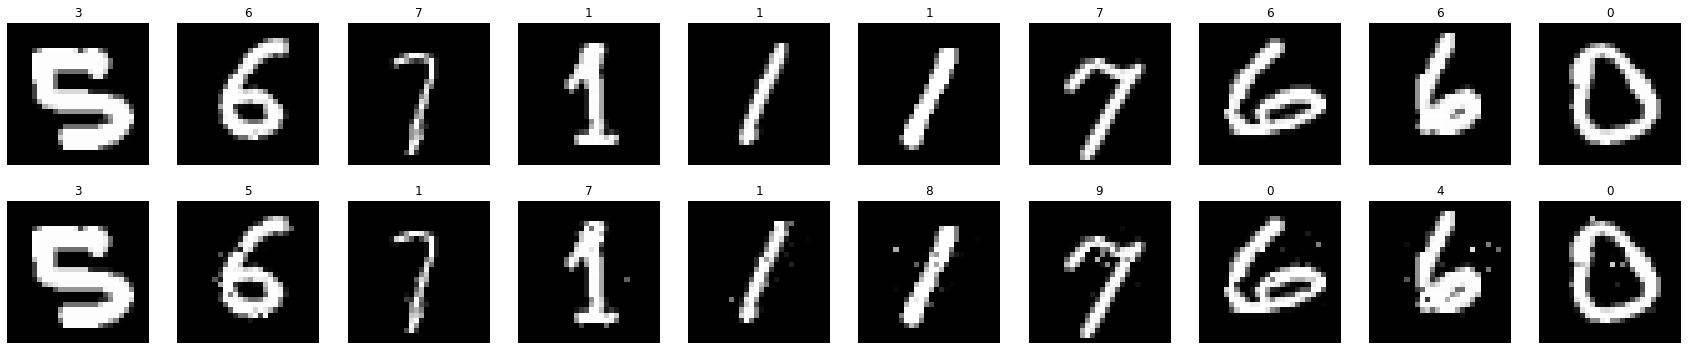

In [11]:
N_FIGS = 10
selected_indices = np.random.choice(SIZE, size=N_FIGS, replace=False)
fig, axs = plt.subplots(nrows=2, ncols=N_FIGS,figsize=(N_FIGS*3, 2*3 ))

for i in range(N_FIGS):
    axs[0,i].imshow(X_test[selected_indices[i]].reshape(28, 28),
                    interpolation='none', vmin=-1.0, vmax=1.0, cmap=plt.cm.gray_r)
    axs[0,i].set_title(str(y_pred[selected_indices[i]]))
    axs[0,i].axis('off')

    axs[1,i].imshow(X_adv[selected_indices[i]].reshape(28, 28),
                    interpolation='none', vmin=-1.0, vmax=1.0, cmap=plt.cm.gray_r)
    axs[1,i].set_title(str(adv_pred[selected_indices[i]]))
    axs[1,i].axis('off')
fig.show()

In [12]:
l2_norm = np.mean(np.linalg.norm(X_test[:SIZE] - X_adv, axis=1))
print('Average l2 norm = {:.3f}'.format(l2_norm))

Average l2 norm = 2.298
